In [1]:
%matplotlib inline
import os

import cftime

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import cmocean

import cartopy
import cartopy.crs as ccrs

import esmlab

import intake
import intake_esm
import ncar_jobqueue
from dask.distributed import Client
from pint import UnitRegistry

units = UnitRegistry()
units.define('micromoles_per_kilogram = umol / kg') # used in WOA datasets

%load_ext watermark
%watermark -a "Mike Levy" -d -iv -m -g -h

intake_esm    2019.10.15.post40
numpy         1.17.3
matplotlib    3.1.2
xarray        0.14.0
cmocean       2.0
intake        0.5.3
ncar_jobqueue 2019.10.16.1
cartopy       0.17.0
cftime        1.0.3.4
esmlab        2019.4.27.post55
Mike Levy 2019-12-10 

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-693.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 72
interpreter: 64bit
host name  : casper11
Git hash   : 02b1538fa3c6fc68f8175e229934082a2aa129d5


In [2]:
cluster = ncar_jobqueue.NCARCluster(project='P93300606')
client = Client(cluster)
client

Client Scheduler: tcp://128.117.181.217:32959 Dashboard: https://jupyterhub.ucar.edu/dav/user/mlevy/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
cluster.scale(4)

In [4]:
datastore_catalog = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm1-le.json'
my_catalog = '/glade/work/mlevy/intake-esm-collection/json/glade-cesm1-le.json'

catalog = intake.open_esm_datastore(my_catalog)

In [5]:
lens_test = catalog.search(component='ocn', variable='O2_ZMIN')
dq = lens_test.to_dataset_dict(cdf_kwargs={'chunks':{'time': 48}})
dq

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'

--> There will be 5 group(s)


{'ocn.20C.pop.h': <xarray.Dataset>
 Dimensions:               (d2: 2, lat_aux_grid: 395, member_id: 34, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 1872, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
 Coordinates:
     TLAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     TLONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     ULONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     ULAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
   * time                  (time) object 1850-02-01 00:00:00 ... 2006-01-01 00:00:00
   * lat_aux_grid          (lat_aux_grid) float32 -79.48815 -78.952896 ... 90.0
   * z_w                   (z_w) float32 0.0 1000.0 2000.0 ... 500004.7 525000.94
   * z_t                   (z_t) float32 500.0 1500.0 ... 512502.8 537500.0
   * z_t_150m 

In [6]:
# Lots of data in the dataset is un-necessary -- these are the variables we really want to keep
keep_vars = ['REGION_MASK', 'z_t', 'dz', 'TAREA', 'TLONG', 'TLAT', 'time', 'time_bound', 'member_id', 'O2_ZMIN']

ds = dict()
for exp in ['20C', '20C-OIC', 'RCP45', 'RCP85']:
    if 'RCP' in exp:
        # This should return everything from 2070s (01-15 instead of 01-01 looks weird but it's due to how date stamps / time bounds are kept)
        time_slice = slice('2070-01-15', '2080-01-15')
    else:
        # This should return everything from 1990s (01-15 instead of 01-01 looks weird but it's due to how date stamps / time bounds are kept)
        time_slice = slice('1990-01-15', '2000-01-15')
    ds[exp] = dq['ocn.{}.pop.h'.format(exp)]
    ds[exp] = ds[exp].drop([v for v in ds[exp].variables if v not in keep_vars]).sel(time=time_slice).mean(dim=['member_id', 'time'])

ds

{'20C': <xarray.Dataset>
 Dimensions:      (nlat: 384, nlon: 320, z_t: 60)
 Coordinates:
     TLAT         (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     TLONG        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
   * z_t          (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
 Dimensions without coordinates: nlat, nlon
 Data variables:
     TAREA        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     dz           (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
     REGION_MASK  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     O2_ZMIN      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
 Attributes:
     Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
     revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
     tavg_sum:                  2592000.0
     intake_esm_varname:        O2_

CPU times: user 1.82 s, sys: 129 ms, total: 1.95 s
Wall time: 7.5 s


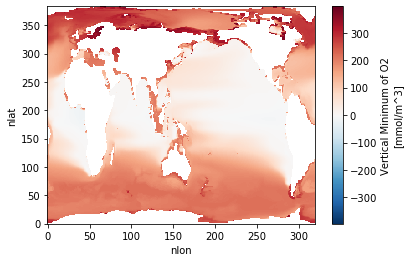

In [7]:
%%time

ds['20C'].O2_ZMIN.plot()

CPU times: user 542 ms, sys: 41.7 ms, total: 584 ms
Wall time: 2.4 s


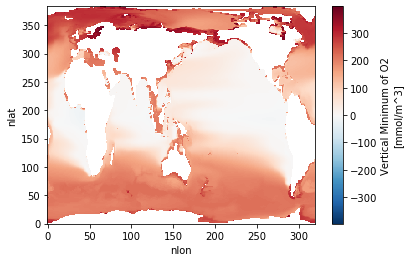

In [8]:
%%time

ds['20C-OIC'].O2_ZMIN.plot()

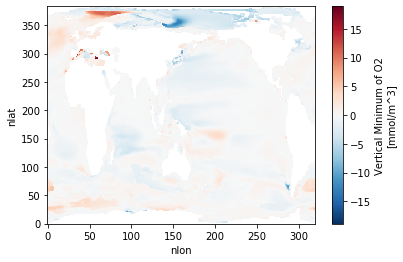

In [9]:
bias = ds['20C-OIC'].O2_ZMIN - ds['20C'].O2_ZMIN
bias.plot()

CPU times: user 260 ms, sys: 32.3 ms, total: 292 ms
Wall time: 1.74 s


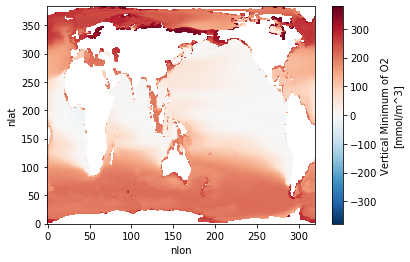

In [10]:
%%time

ds['RCP45'].O2_ZMIN.plot()

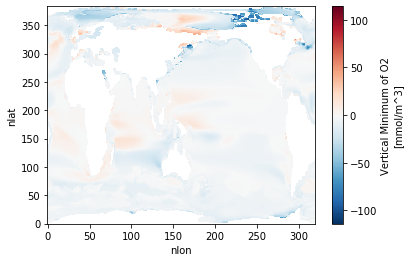

In [11]:
bias = ds['RCP45'].O2_ZMIN - ds['20C'].O2_ZMIN
bias.plot()

CPU times: user 1.06 s, sys: 79.2 ms, total: 1.13 s
Wall time: 5.98 s


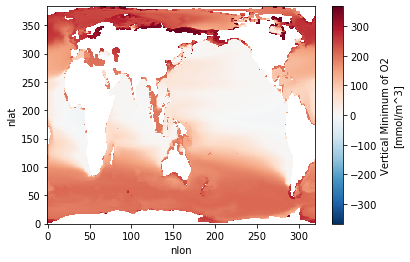

In [12]:
%%time

ds['RCP85'].O2_ZMIN.plot()

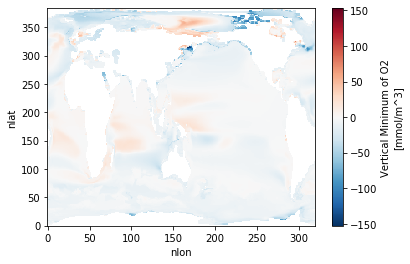

In [13]:
bias = ds['RCP85'].O2_ZMIN - ds['20C'].O2_ZMIN
bias.plot()